In [1]:
import glob, os
import tqdm
import h5py

In [2]:
filepat = "image_*.h5"
print(glob.glob(filepat)[0:5]) # glob.glob() return a list of filename

['image_0320.h5', 'image_0909.h5', 'image_0964.h5', 'image_0583.h5', 'image_0883.h5']


In [3]:
fns = list(map(os.path.relpath, glob.glob(filepat))) # os.path.repath() return the real path of 
print(fns[0:5])

['image_0320.h5', 'image_0909.h5', 'image_0964.h5', 'image_0583.h5', 'image_0883.h5']


data
<HDF5 dataset "data": shape (516, 516), type "<i4">
<Attributes of HDF5 object at 139729391318896>
{'DeadPixelCorrection': True, 'FlatfieldCorrection': True, 'ImageBinSize': 1, 'ImageCameraDimensions': array([512, 512], dtype=int32), 'ImageCameraName': b'timepix', 'ImageComment': b'Hole 0 image 320\n', 'ImageDimensions': array([5.95843657, 5.95843657]), 'ImageExposureTime': 0.2, 'ImageGetTime': b'Tue Mar 07 16:20:47 2017', 'ImageResolution': array([516, 516]), 'compression': False, 'compression_type': 1, 'date': b'Tue Mar 07 16:20:48 2017', 'exp_crystal_coords': array([], dtype=float64), 'exp_hole_center': array([-821348.875 ,  627688.8125]), 'exp_hole_number': 0, 'exp_hole_offset': array([99780.38363116, 26960.25444973]), 'exp_image_number': 320, 'exp_image_spotsize': 4, 'exp_magnification': 2500, 'exp_neutral_beamshift': array([32832, 34524], dtype=int32), 'exp_neutral_diffshift': array([33651, 31625], dtype=int32), 'nBits': 32, 'nColumns': 516, 'nRows': 516, 'photometricInterpr

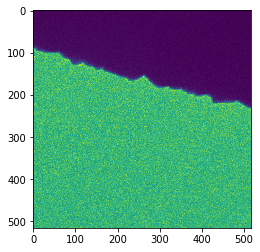

In [12]:
import numpy as np
import matplotlib.pyplot as plt

f1 = h5py.File("image_0320.h5")
def prtname(name):
    print(name)
f1.visit(prtname)  # the image has dataset: data
print(f1["data"]) # return the dataset object of h5py
print(f1["data"].attrs) # return the attrs object of dataset
print(dict(f1["data"].attrs)) # extract the attrs into dict
f1_array = np.array(f1["data"]) # extract the dataset into numpy array
plt.imshow(f1_array)
plt.show()


In [14]:
def read_hdf5(fname):  # a simple function to extract the dataset and related attrs in h5 file
    f = h5py.File(fname)
    return np.array(f["data"]), dict(f["data"].attrs)

In [15]:
def get_stage_coords(fns):
    coords = []
    has_crystals = []
    t = tqdm.tqdm(fns, desc="Parsing files")  # tqdm is used for progress bar
    for fn in t:
        img, h = read_hdf5(fn) # img: image of numpy array, h: dict, record the attrs of image 
        try:
            dx, dy = h["exp_hole_offset"]  # coordinates
            cx, cy = h["exp_hole_center"]  # coordinates
        except KeyError:
            dx, dy = h["exp_scan_offset"]
            cx, cy = h["exp_scan_center"]
        coords.append((cx + dx, cy + dy)) # record all stage coords

        has_crystals.append(len(h["exp_crystal_coords"]) > 0) # return a bool list, record the information of existing crystals
    # convert to um
    return np.array(coords) / 1000, np.array(has_crystals) # return all the coords of stages and bool list of crystals

In [16]:
coords, has_crystals = get_stage_coordｓ(fns)

Parsing files: 100%|██████████| 442/442 [00:04<00:00, 104.02it/s]


In [22]:
print(coords[0:5])
print(has_crystals[0:5])

[[-721.56849137  654.64906695]
 [-958.98897081  632.33669982]
 [-969.55924818  644.63445997]
 [-832.35102306  634.26956327]
 [-818.42847046  742.46087079]]
[False  True  True  True False]


In [21]:
print(coords.shape, has_crystals.shape)
print(coords[has_crystals==True, 0], coords[has_crystals==True, 0].shape)

(442, 2) (442,)
[-958.98897081 -969.55924818 -832.35102306 -822.74717742 -951.00991762
 -750.48271863 -798.81001784 -754.90411592 -769.03204919 -835.04493757
 -935.15450157 -881.54206367 -862.99273311 -898.36391145 -758.46177182
 -769.99848092 -746.16401167 -793.73025983 -953.70383213 -731.06964668
 -804.95889792 -870.10804491 -929.86936288 -815.63186562 -847.44538806
 -762.01942772 -957.15879769 -904.51279152 -799.01539851 -870.9717863
 -900.09139423 -894.80625555 -726.95632039 -899.22765284 -862.33437238
 -859.74314821 -965.13785089 -797.08253506 -844.75147355 -841.19381765
 -722.53492309 -821.7807457  -888.65737547 -775.2836196  -940.54233058
 -696.10922967 -769.13473952 -804.09515653 -911.52541299 -804.19784686
 -914.87768822 -680.15112329 -869.14161318 -915.94681028 -746.06132134
 -853.59426813 -686.30000336 -798.15165712 -791.13903565 -858.67402615
 -812.27959039 -779.39694589 -774.31718787 -892.21503137 -900.95513562
 -787.37599908 -879.81458089 -797.94627645 -684.57252058 -851.

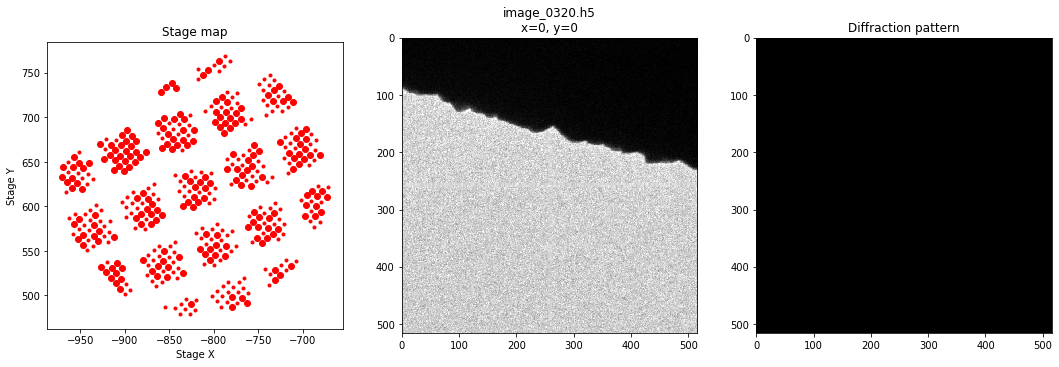

In [30]:
fn = fns[0]
img, h = read_hdf5(fn)

fig = plt.figure(figsize=(18, 6))
fig.canvas.set_window_title('Problematic.browser')
coord_color = 'red'
picked_color = "blue"

ax1 = plt.subplot(131, title='Stage map', aspect='equal') 
ax1.scatter(coords[has_crystals==True, 0], coords[has_crystals== True, 1], marker= 'o', facecolor=coord_color) # return scatter diagram, prams:list of x,y includ crystal
ax1.scatter(coords[:, 0], coords[:, 1], marker=".", color=coord_color, picker=8) # all coords
highlight1, = ax1.plot([], [], marker="o", color=picked_color) # ???

ax1.set_xlabel("Stage X")
ax1.set_ylabel("Stage Y")

ax2 = plt.subplot(132, title="{}\nx={}, y={}".format(fn, 0, 0))
im2 = ax2.imshow(img, cmap="gray", vmax=np.percentile(img, 99.5))
plt_crystals, = ax2.plot([], [], marker="+", color="red",  mew=2, picker=8, lw=0)
highlight2,   = ax2.plot([], [], marker="+", color="blue", mew=2)

ax3 = plt.subplot(133, title="Diffraction pattern")
im3 = ax3.imshow(np.zeros_like(img), vmax=np.percentile(img, 99.5), cmap="gray")



